<a href="https://colab.research.google.com/github/RahulV-31/Spam-Detection-Using-DistilBERT/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch numpy pandas scikit-learn tqdm

import numpy as np
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!unzip '/content/archive(1).zip'

Archive:  /content/archive(1).zip
  inflating: combined_data.csv       


In [ ]:
# ✅ 1️⃣ Load Dataset
df=pd.read_csv('/content/combined_data.csv')
df = df[['label', 'text']]  # Keep relevant columns

# Convert labels to 0 (Ham) and 1 (Spam) if needed
df['label'] = df['label'].astype(int)

# Sample dataset for quick testing (Optional)
# df = df.sample(2000, random_state=42)  # Uncomment to test on 2000 samples first

print(df.head())

   label                                               text
0      1  ounce feather bowl hummingbird opec moment ala...
1      1  wulvob get your medircations online qnb ikud v...
2      0   computer connection from cnn com wednesday es...
3      1  university degree obtain a prosperous future m...
4      0  thanks for all your answers guys i know i shou...


In [ ]:
# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.half().to(device)  # Convert to float16 for efficiency

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
def batch_bert_embeddings(texts, batch_size=32):
    """Convert emails to BERT embeddings in batches."""
    all_embeddings = []
    dataloader = DataLoader(texts, batch_size=batch_size, shuffle=False)

    bert_model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradients for inference
        for batch_texts in tqdm(dataloader, desc="Processing Batches"):
            tokens = tokenizer(batch_texts, padding=True, truncation=True, max_length=64, return_tensors="pt")
            tokens = {key: val.to(device) for key, val in tokens.items()}  # Move to GPU

            outputs = bert_model(**tokens)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Move back to CPU
            all_embeddings.extend(batch_embeddings)

    return np.array(all_embeddings)

# Convert email texts to BERT embeddings
X_bert = batch_bert_embeddings(df["text"].tolist())
y = df["label"].values

print("Shape of X_bert:", X_bert.shape)  # Should be (num_samples, 768)

Processing Batches: 100%|██████████| 2608/2608 [08:25<00:00,  5.16it/s]


Shape of X_bert: (83448, 768)


In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)

# Train Logistic Regression Model
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

# Predict on Test Data
y_pred = clf.predict(X_test)

# Evaluate Model Performance
print("\n🔹 Logistic Regression Model Performance:\n")
print(classification_report(y_test, y_pred))


🔹 Logistic Regression Model Performance:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7938
           1       0.96      0.97      0.96      8752

    accuracy                           0.96     16690
   macro avg       0.96      0.96      0.96     16690
weighted avg       0.96      0.96      0.96     16690



In [ ]:
emails = [
    "You've won a brand-new iPhone! Claim your prize now.",  # Spam
    "Hey, let's catch up over coffee this weekend!",  # Ham
    "Your bank account has been locked due to suspicious activity. Click here to verify.",  # Spam
    "Reminder: Our team meeting is scheduled for 10 AM tomorrow.",  # Ham
    "Final notice: Your free gift is about to expire. Claim it now!",  # Spam
    "Can you send me the updated report by EOD?",  # Ham
    "Congratulations! You have been selected for an exclusive discount.",  # Spam
    "Please review the attached document and let me know your thoughts.",  # Ham
    "Act fast! Get 50% off on all purchases for the next 24 hours.",  # Spam
    "Meeting rescheduled to 3 PM. Let me know if that works.",  # Ham
]

# Convert real-world emails to BERT embeddings (batch processing)
real_email_embeddings = batch_bert_embeddings(emails)  # Use optimized function

# Predict spam or ham
real_preds = clf.predict(real_email_embeddings)  # Use trained model

# Print predictions
for email, pred in zip(emails, real_preds):
    print(f"\n📩 Email: {email}")
    print(f"🔹 Prediction: {'Spam' if pred == 1 else 'Ham'}")

Processing Batches: 100%|██████████| 1/1 [00:00<00:00, 102.03it/s]


📩 Email: You've won a brand-new iPhone! Claim your prize now.
🔹 Prediction: Spam

📩 Email: Hey, let's catch up over coffee this weekend!
🔹 Prediction: Ham

📩 Email: Your bank account has been locked due to suspicious activity. Click here to verify.
🔹 Prediction: Spam

📩 Email: Reminder: Our team meeting is scheduled for 10 AM tomorrow.
🔹 Prediction: Ham

📩 Email: Final notice: Your free gift is about to expire. Claim it now!
🔹 Prediction: Spam

📩 Email: Can you send me the updated report by EOD?
🔹 Prediction: Ham

📩 Email: Congratulations! You have been selected for an exclusive discount.
🔹 Prediction: Spam

📩 Email: Please review the attached document and let me know your thoughts.
🔹 Prediction: Ham

📩 Email: Act fast! Get 50% off on all purchases for the next 24 hours.
🔹 Prediction: Spam

📩 Email: Meeting rescheduled to 3 PM. Let me know if that works.
🔹 Prediction: Ham


In [ ]:
import joblib

# Save the trained logistic regression model
joblib.dump(clf, "spam_classifier_model.pkl")

# Save the BERT embeddings (optional, if you want to avoid recomputing them later)
np.save("X_bert_embeddings.npy", X_bert)
np.save("y_labels.npy", y)

print("✅ Model and embeddings saved successfully!")


✅ Model and embeddings saved successfully!


#Load the Model Later



In [ ]:
# Load the logistic regression model
clf_loaded = joblib.load("spam_classifier_model.pkl")

# Load saved BERT embeddings (if needed)
X_bert_loaded = np.load("X_bert_embeddings.npy")
y_loaded = np.load("y_labels.npy")

print("✅ Model and data loaded successfully!")


✅ Model and data loaded successfully!


#Test with Saved Model



In [ ]:
# Convert test emails to BERT embeddings (batch processing)
real_email_embeddings = batch_bert_embeddings(real_emails)  # Use optimized function

# Predict using the loaded model
real_preds = clf_loaded.predict(real_email_embeddings)

# Print predictions
for email, pred in zip(real_emails, real_preds):
    print(f"\n📩 Email: {email}")
    print(f"🔹 Prediction: {'Spam' if pred == 1 else 'Ham'}")


Processing Batches: 100%|██████████| 1/1 [00:00<00:00, 100.96it/s]


📩 Email: Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize.
🔹 Prediction: Spam

📩 Email: Hi John, let's meet tomorrow to discuss the project.
🔹 Prediction: Ham

📩 Email: URGENT: Your bank account has been compromised. Click here to secure it.
🔹 Prediction: Spam

📩 Email: Hey, can you send me the report by EOD?
🔹 Prediction: Ham

📩 Email: You have been selected for a free iPhone. Click here to claim now!
🔹 Prediction: Spam


In [ ]:
!pip install wordcloud

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import pandas as pd


Processing Batches: 100%|██████████| 1/1 [00:00<00:00, 46.79it/s]



📩 Email: You've won a brand-new iPhone! Claim your prize now.
🔹 Prediction: Spam


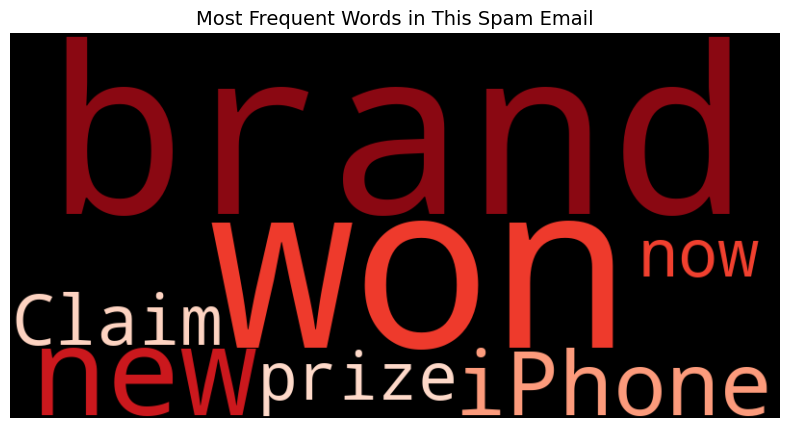

Processing Batches: 100%|██████████| 1/1 [00:00<00:00, 60.74it/s]



📩 Email: Hey, let's catch up over coffee this weekend!
🔹 Prediction: Ham


Processing Batches: 100%|██████████| 1/1 [00:00<00:00, 110.20it/s]



📩 Email: Your bank account has been locked due to suspicious activity. Click here to verify.
🔹 Prediction: Spam


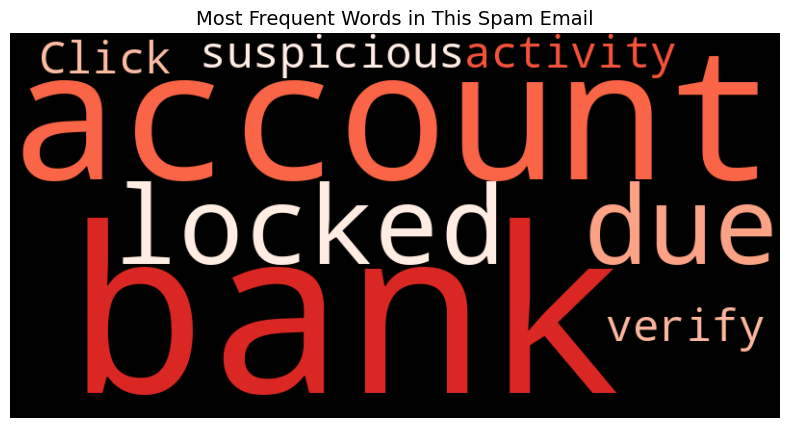

Processing Batches: 100%|██████████| 1/1 [00:00<00:00, 107.14it/s]



📩 Email: Reminder: Our team meeting is scheduled for 10 AM tomorrow.
🔹 Prediction: Ham


Processing Batches: 100%|██████████| 1/1 [00:00<00:00, 118.95it/s]



📩 Email: Final notice: Your free gift is about to expire. Claim it now!
🔹 Prediction: Spam


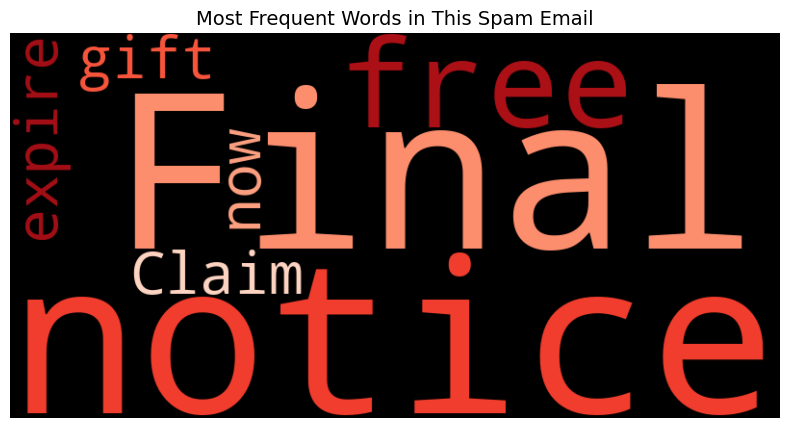

Processing Batches: 100%|██████████| 1/1 [00:00<00:00, 65.56it/s]



📩 Email: Can you send me the updated report by EOD?
🔹 Prediction: Ham


Processing Batches: 100%|██████████| 1/1 [00:00<00:00, 47.01it/s]



📩 Email: Congratulations! You have been selected for an exclusive discount.
🔹 Prediction: Spam


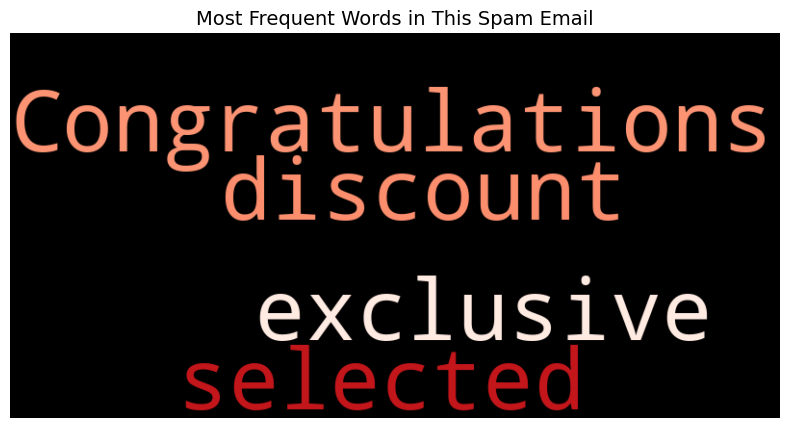

Processing Batches: 100%|██████████| 1/1 [00:00<00:00, 97.70it/s]



📩 Email: Please review the attached document and let me know your thoughts.
🔹 Prediction: Ham


Processing Batches: 100%|██████████| 1/1 [00:00<00:00, 110.14it/s]



📩 Email: Act fast! Get 50% off on all purchases for the next 24 hours.
🔹 Prediction: Spam


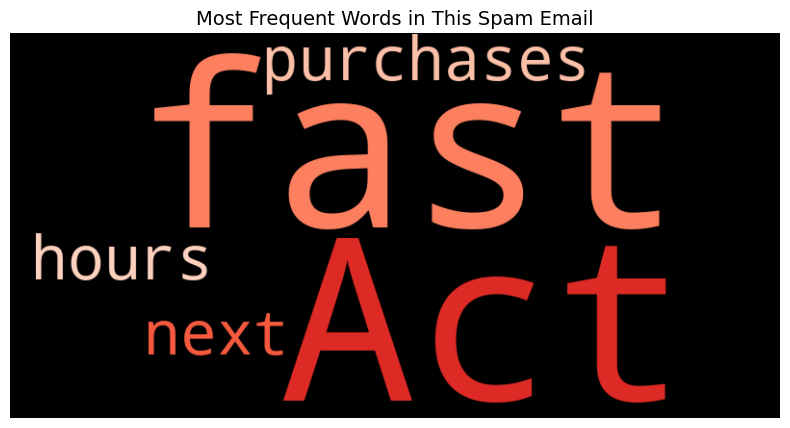

Processing Batches: 100%|██████████| 1/1 [00:00<00:00, 109.25it/s]


📩 Email: Meeting rescheduled to 3 PM. Let me know if that works.
🔹 Prediction: Ham


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import joblib
import numpy as np

# Load trained model
clf_loaded = joblib.load("spam_classifier_model.pkl")

# Function to predict spam or ham & show Word Cloud if spam
def predict_and_show_wordcloud(email_text):
    # Convert input email to BERT embedding
    email_embedding = batch_bert_embeddings([email_text])

    # Predict Spam or Ham
    pred = clf_loaded.predict(email_embedding)[0]
    result = "Spam" if pred == 1 else "Ham"

    # Display result
    print(f"\n📩 Email: {email_text}")
    print(f"🔹 Prediction: {result}")

    # Show Word Cloud **only for spam emails & based on this email's words**
    if pred == 1:
        wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(email_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Most Frequent Words in This Spam Email", fontsize=14)
        plt.show()

# Test Multiple Emails
email_samples = [
    "You've won a brand-new iPhone! Claim your prize now.",  # Spam
    "Hey, let's catch up over coffee this weekend!",  # Ham
    "Your bank account has been locked due to suspicious activity. Click here to verify.",  # Spam
    "Reminder: Our team meeting is scheduled for 10 AM tomorrow.",  # Ham
    "Final notice: Your free gift is about to expire. Claim it now!",  # Spam
    "Can you send me the updated report by EOD?",  # Ham
    "Congratulations! You have been selected for an exclusive discount.",  # Spam
    "Please review the attached document and let me know your thoughts.",  # Ham
    "Act fast! Get 50% off on all purchases for the next 24 hours.",  # Spam
    "Meeting rescheduled to 3 PM. Let me know if that works.",  # Ham
]

# Run function for each email in the list
for email in email_samples:
    predict_and_show_wordcloud(email)
